## Stardist training example

In [1]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from pathlib import Path
import json

2024-07-21 09:12:05.897574: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 09:12:05.907888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 09:12:05.922105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 09:12:05.922131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 09:12:05.931131: I tensorflow/core/platform/cpu_feature_gua

## Check what devices we have access to....

Not as important to have a beefy GPU for 2D as it is for 3D, but let's check

In [2]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-21 09:12:53.987052: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 09:12:54.027868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 09:12:54.028030: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is simply because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [5]:

tnia_images_path = Path(r'/home/bnorthan/images')
#tnia_images_path = Path("D:/images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_07_11_cellpose_with_dentrites')
#test_name='bsp1-2.jpg'
n_rays = 32

train_path = parent_path / 'patches'

with open(train_path / 'info.json', 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data['sub_sample']
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

image_patch_path = train_path / 'ground truth0'
label_patch_path = train_path / 'input0'

model_path = parent_path / 'model'

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

sub_sample 1
axes YX


## Use a helper to collect the training data

The helper will also optionally normalize the inputs.

Normalization is a tricky issue sometimes it makes sense to normalize before creating patches, such that the data is normalized based on statistics of a larger region, closer to the normalization range that will be used for prediction. 

In [6]:
from tnia.deeplearning.dl_helper import collect_training_data
add_trivial_channel = False

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel = add_trivial_channel)

print('type X ', type(X))
print('type Y ', type(Y))

raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist
type X  <class 'list'>
type Y  <class 'list'>


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(256, 256) (256, 256)
0.0 1.0


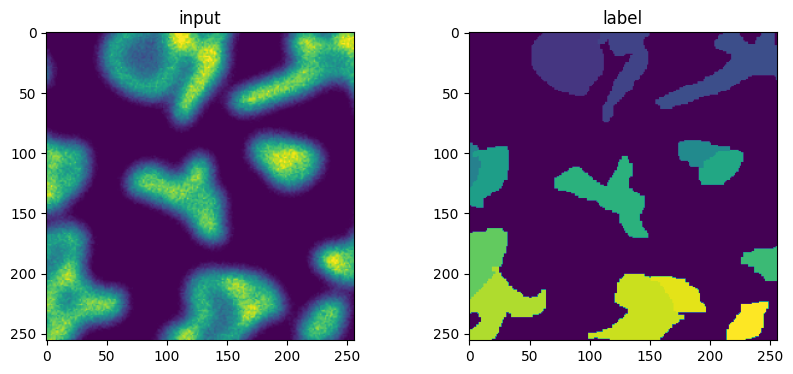

In [8]:
n=44
print(X[n].shape, Y[n].shape)
print(X[n].min(), X[n].max())
fig=imshow_multi2d([X[n], Y[n]], ['input', 'label'], 1,2)

In [9]:
print(X[0].dtype, Y[0].dtype)

float32 int32


## Divide in to training and validation sets

Use a helper to divide into training and validation.  Note the conversion to numpy arrays (needed for stardist training) is also baked into the divide_training_data function

In [10]:
from tnia.deeplearning.dl_helper import divide_training_data

X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, val_size=2)

print('type X_train ', type(X_train))

type X_train  <class 'numpy.ndarray'>


## Create stardist model

In this cell we create the model.  Make sure to rename the model and give it a descriptive name that conveys the training data and setting used. 

In [11]:
from stardist.models import StarDist2D, Config2D
from tnia.deeplearning.dl_helper import augmenter

if axes == 'YXC':
    n_channel_in =3
else:
    n_channel_in = 1

config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (256,256), unet_n_depth=3)

model = StarDist2D(config=config, name="model_second_try", basedir=model_path)

Using default values: prob_thresh=0.5, nms_thresh=0.4.


2024-07-21 09:13:58.343150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 09:13:58.343485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 09:13:58.343650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Train the model

In [12]:
X_val.shape, Y_val.shape

((2, 256, 256), (2, 256, 256))

In [13]:
X_train.shape, Y_train.shape

((198, 256, 256), (198, 256, 256))

In [14]:
import napari
viewer = napari.Viewer()

In [61]:
print(config)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(1, 1), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

In [15]:
#model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=100, steps_per_epoch=200, augmenter=augmenter) 
model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=80, steps_per_epoch=10) 

Epoch 1/80


I0000 00:00:1721567661.384445   98293 service.cc:145] XLA service 0x77d224004990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721567661.384487   98293 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-07-21 09:14:21.488796: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-21 09:14:27.012185: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - dist_dist_iou_metric: 1.1734e-06 - dist_relevant_mae: 16.7510 - dist_relevant_mse: 442.9451 - loss: 4.0436 - prob_kld: 0.5420 

I0000 00:00:1721567677.156732   98293 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 953ms/step - dist_dist_iou_metric: 5.7150e-05 - dist_relevant_mae: 17.0457 - dist_relevant_mse: 458.5985 - loss: 4.0669 - prob_kld: 0.5058 - val_dist_dist_iou_metric: 6.9116e-04 - val_dist_relevant_mae: 16.5636 - val_dist_relevant_mse: 438.6748 - val_loss: 3.8347 - val_prob_kld: 0.3758 - learning_rate: 3.0000e-04
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - dist_dist_iou_metric: 8.8096e-04 - dist_relevant_mae: 16.7656 - dist_relevant_mse: 453.8450 - loss: 3.8382 - prob_kld: 0.3357 - val_dist_dist_iou_metric: 0.0023 - val_dist_relevant_mae: 16.1272 - val_dist_relevant_mse: 424.1399 - val_loss: 3.6408 - val_prob_kld: 0.2692 - learning_rate: 3.0000e-04
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - dist_dist_iou_metric: 0.0113 - dist_relevant_mae: 15.5222 - dist_relevant_mse: 403.2878 - loss: 3.5339 - prob_kld: 0.2824 - val_dist_dist_iou_metric: 0.1523 - val_dist_relevant_mae: 11.5865 - val_dist_relevant_mse: 269.5122 - val_loss: 2.9883 - val_p

In [16]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:02<00:00,  6.17it/s, 0.646 -> 0.284]


Using optimized values: prob_thresh=0.644344, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.6443437075219651, 'nms': 0.4}

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

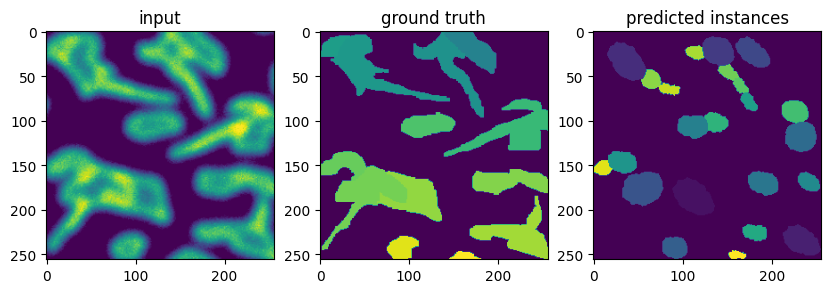

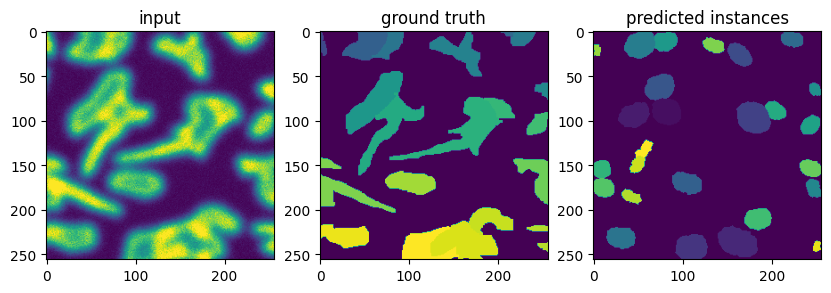

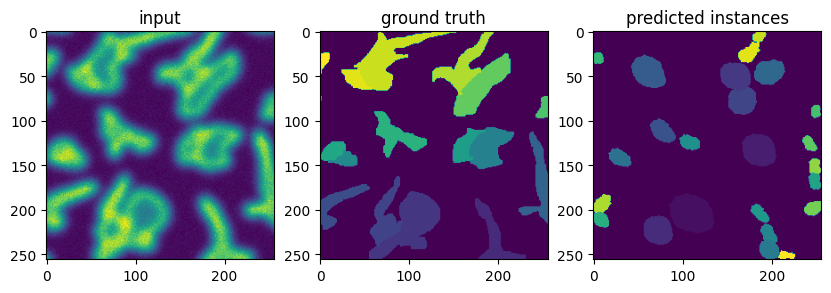

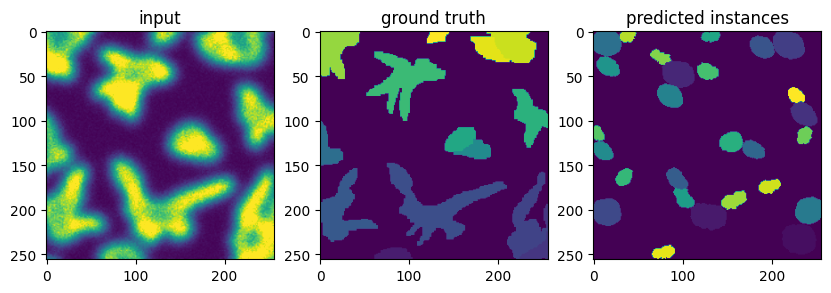

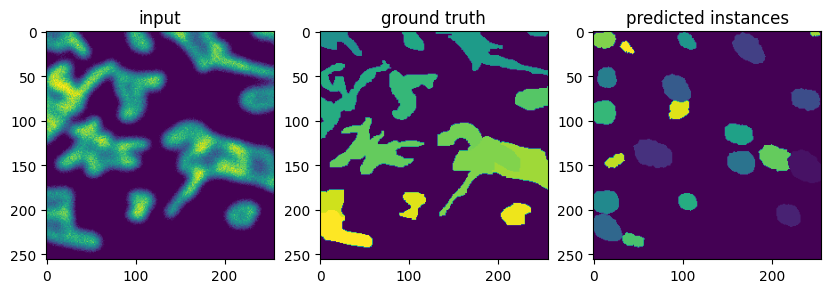

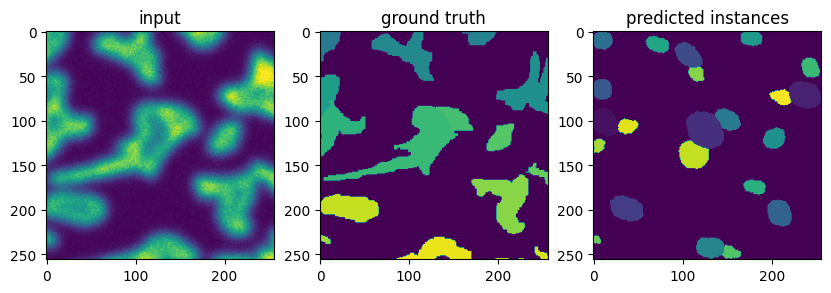

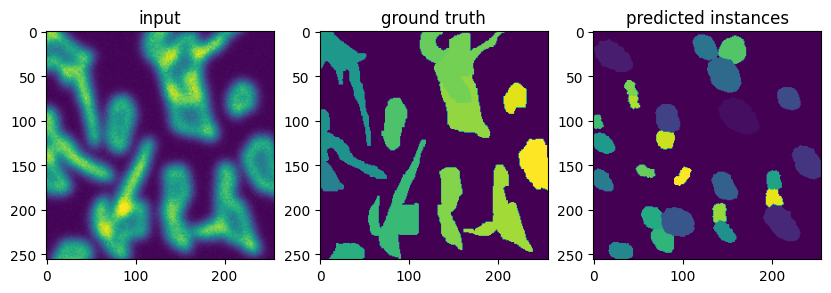

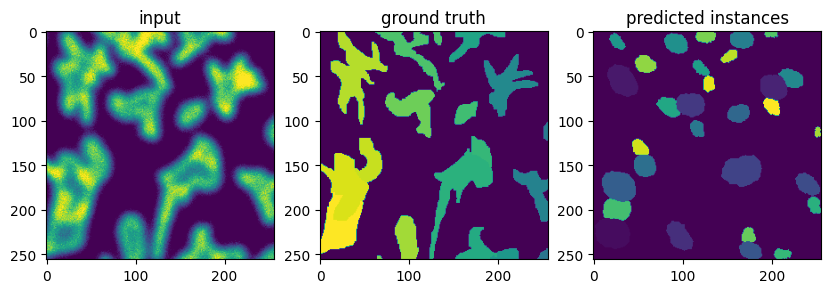

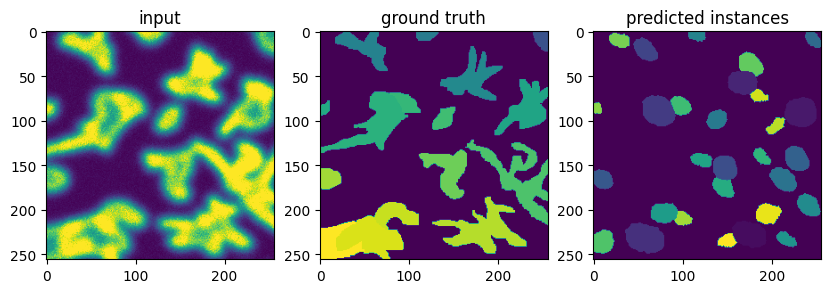

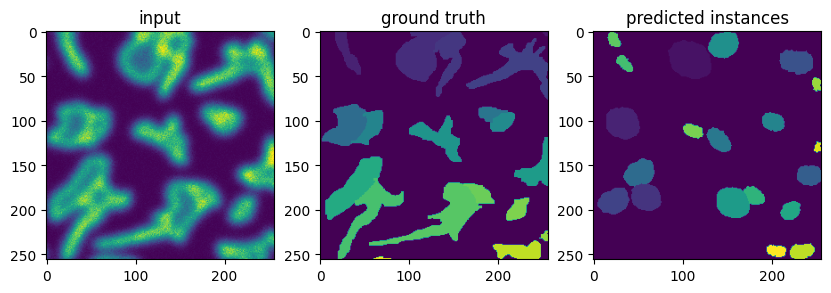

In [17]:
for n in range(10):
    labels, details = model.predict_instances(X_train[n], prob_thresh=0.5, nms_thresh=0.1)
    fig = imshow_multi2d([X_train[n],Y_train[n],labels],['input','ground truth','predicted instances'],1,3)


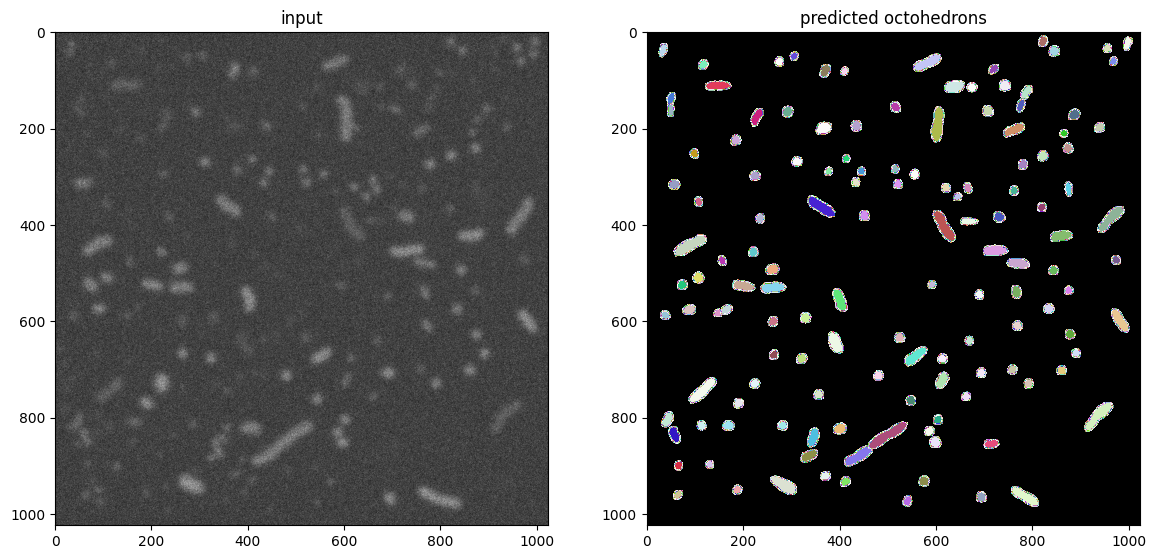

In [64]:
from skimage.io import imread
from tnia.plotting.plt_helper import random_label_cmap
from tnia.deeplearning.dl_helper import ray4_to_ellipsoid2d_labels
from csbdeep.utils import normalize
import numpy as np
test_name='phantom2.tif'
testim = imread(parent_path  / test_name) 
if (sub_sample != 1):
    testim = testim[::sub_sample,::sub_sample]  
testim = normalize(testim,1,99.8, axis=(0,1))
labels, details = model.predict_instances(testim, prob_thresh=0.5, nms_thresh=0.1)

if n_rays == 4:
    labels2 = np.zeros_like(labels)#ray4_to_ellipsoid2d_labels(details['coord'], testim.shape)
    fig = imshow_multi2d([testim,labels,labels2],['input','predicted octohedrons', 'rendered as ellipses'],1,3, width=14, height=8,colormaps=['gray', random_label_cmap(), random_label_cmap()])
else:
    fig = imshow_multi2d([testim,labels],['input','predicted octohedrons'],1,2, width=14, height=8,colormaps=['gray', random_label_cmap()])

In [1]:
import napari

viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels2')

NameError: name 'testim' is not defined